# Supervised training with RANS

In [5]:
%reset -f

In [6]:
import numpy as np
import os.path, random

# import torch
# from torch.utils.data import Dataset
# print("Torch version {} ".format(torch.__version__))

# get training data
os.makedirs("./temp/", exist_ok=True)
dir = "./temp/"
if True:
    # download
    if not os.path.isfile(dir+'data-airfoils.npz'):
        import requests
        print("Downloading training data (300MB), this can take a few minutes the first time...")
        with open(dir+"data-airfoils.npz", 'wb') as datafile:
            resp = requests.get('https://dataserv.ub.tum.de/s/m1615239/download?path=%2F&files=dfp-data-400.npz', verify=False)
            datafile.write(resp.content)
else:
    # alternative: load from google drive (upload there beforehand):
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "./gdrive/My Drive/"

npfile=np.load(dir+'data-airfoils.npz', allow_pickle=True)
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))
print("Size of the inputs array: "+format(npfile["inputs"].shape))

Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


Stats 0 : [-0.3255776199086798, 0.23393399824079095, 0.47048169549735686]
Stats 1 : [-0.6548143700240462, 0.017164150495987723, 0.8552243695079386]
Stats 2 : [-0.5325950274411584, -0.04987998400700594, 1.0]


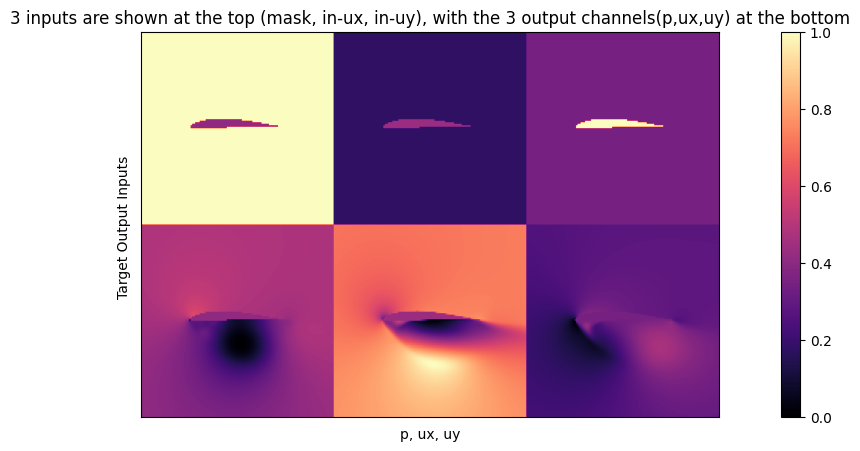

In [7]:
import pylab
# helper to show three target channels: normalized, with colormap, side by side
def showSbs(a1,a2, stats=False, bottom="NN Output", top="Reference", title=None):
    c=[]
    for i in range(3):
        b = np.flipud( np.concatenate((a2[i],a1[i]),axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b);
        if stats: print("Stats %d : "%i + format([min,mean,max]))
        b -= min; b /= (max-min)
        c.append(b)
    fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
    axes.set_xticks([]); axes.set_yticks([]);
    im = axes.imshow(np.concatenate(c,axis=1), origin='upper', cmap='magma')

    pylab.colorbar(im); pylab.xlabel('p, ux, uy'); pylab.ylabel('%s %s '%(bottom,top))
    if title is not None: pylab.title(title)

NUM=72
showSbs(npfile["inputs"][NUM],npfile["targets"][NUM], stats=True, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (mask, in-ux, in-uy), with the 3 output channels(p,ux,uy) at the bottom")

In [8]:
# some global training constants
# number of training epochs
EPOCHS = 100
# batch size
BATCH_SIZE = 10
# learning rate
LR = 0.00002

class DfpDataset():
    def __init__(self, inputs,targets):
        self.inputs = inputs
        self.targets = targets
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
tdata = DfpDataset(npfile["inputs"], npfile["targets"])
vdata = DfpDataset(npfile["vinputs"], npfile["vtargets"])

from torch.utils.data import DataLoader
from utility_functions import numpy_collate_fn
trainLoader = DataLoader(tdata, collate_fn=numpy_collate_fn, batch_size=BATCH_SIZE, shuffle=True , drop_last=True)
valiLoader = DataLoader(vdata, collate_fn=numpy_collate_fn, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print("Training & validation batches: {} , {} ".format(len(trainLoader),len(valiLoader) ))

c:\Users\rouss\miniconda3\envs\jaxenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training & validation batches: 32 , 8 


In [9]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from typing import Any, Tuple

class DfpVnet(nn.Module):
    input_shape: Tuple[int, int, int] = (128, 128, 3)
    output_shape: Tuple[int, int, int] = (128, 128, 3)
    levels: int = 8                             ## Le nombre de niveaux 
    channel_expo: int = 4                       ## Le nombre de channel au niveau 1
    kernel_size: Tuple[int, int] = (4, 4)
    activation: Any = nn.relu
    batch_norm: bool = False
    dropout_rate: float = 0.0

    def downsampling_conv(self, Y, out_feats, name=None):       ## A "convolution" to downsample data
        down = nn.Conv(out_feats, (2, 2), strides=(2, 2), padding="SAME", kernel_init=nn.initializers.normal(0.02))(Y)
        return down

    def upsampling_conv(self, Y, out_feats, name=None):         ## A "convolution" to upsample data
        up = nn.ConvTranspose(out_feats, (2, 2), strides=(2, 2), padding="SAME", kernel_init=nn.initializers.normal(0.02))(Y)
        return up

    def double_conv(self, Y, out_feats, name=None):
        # Y = nn.Conv(out_feats, self.kernel_size, padding='SAME', kernel_init=nn.initializers.normal(0.02))(Y)
        # Y = self.activation(Y)
        Y = nn.Conv(out_feats, self.kernel_size, padding='SAME', kernel_init=nn.initializers.normal(0.02))(Y)
        Y = self.activation(Y)
        if self.batch_norm:
            Y = nn.BatchNorm(use_running_average=True)(Y)       ## A bit more complicated tha this: see https://flax.readthedocs.io/en/latest/guides/batch_norm.html?highlight=train_state
        if self.dropout_rate > 0.0:
            Y = nn.Dropout(self.dropout_rate)(Y)
        return Y

    @nn.compact
    def __call__(self, inputs):

        # assert len(self.input_shape)==3
        # assert len(self.output_shape)==3
        # assert (self.input_shape[0], self.input_shape[1]) == (self.output_shape[0], self.output_shape[1]), "Input and output dimensions should be alike in a Vnet"

        left = {}     ## On sauvegarde la partie gauche à additionner avec la partie droite
        left[0] = self.double_conv(inputs, self.channel_expo)
        # print("left[0].shape =", left[0].shape)
        for i in range(1, self.levels):                           ## Une boucle pour la descente
            down = self.downsampling_conv(left[i-1], self.channel_expo*2**i)
            conv = self.double_conv(down, self.channel_expo*2**i)
            left[i] = down + conv         ## L'addition c'est comme des racourcis à la resnet ## essayons des multiplications
            # if i < self.levels-1:
            #     print(f"left[{i}].shape =",left[i].shape)

        central = left[self.levels-1]
        # print(f"central.shape =", central.shape)

        right = central
        for i in range(self.levels-2, -1,-1):                     ## une boucle pour la remontée
            up = self.upsampling_conv(right, self.channel_expo*2**i)
            add = left[i] + up
            conv = self.double_conv(add, self.channel_expo*2**i)
            right = up + conv
            # print(f"right[{i}].shape =", right.shape)

        logits = nn.Conv(self.output_shape[2], (1, 1))(right)
        outputs = nn.sigmoid(logits)   ## Une sigmoid parceque les données vont éte normalisées
        return outputs

In [10]:
def init_flax_params(net:nn.Module):
    key = jax.random.PRNGKey(0)
    init_data = jnp.ones((1,)+net.input_shape)
    params = net.init(key, init_data)
    # print(net.tabulate(key, init_data, depth=8, console_kwargs={"force_jupyter":False}))
    return params

net = DfpVnet()
params = init_flax_params(net)

In [11]:
from clu import parameter_overview
print(parameter_overview.get_parameter_overview(params))

+-------------------------------+------------------+-----------+-----------+--------+
| Name                          | Shape            | Size      | Mean      | Std    |
+-------------------------------+------------------+-----------+-----------+--------+
| params/ConvTranspose_0/bias   | (256,)           | 256       | 0.0       | 0.0    |
| params/ConvTranspose_0/kernel | (2, 2, 512, 256) | 524,288   | 6.44e-07  | 0.02   |
| params/ConvTranspose_1/bias   | (128,)           | 128       | 0.0       | 0.0    |
| params/ConvTranspose_1/kernel | (2, 2, 256, 128) | 131,072   | -2.05e-05 | 0.02   |
| params/ConvTranspose_2/bias   | (64,)            | 64        | 0.0       | 0.0    |
| params/ConvTranspose_2/kernel | (2, 2, 128, 64)  | 32,768    | -8.37e-05 | 0.02   |
| params/ConvTranspose_3/bias   | (32,)            | 32        | 0.0       | 0.0    |
| params/ConvTranspose_3/kernel | (2, 2, 64, 32)   | 8,192     | 0.000224  | 0.02   |
| params/ConvTranspose_4/bias   | (16,)            | 1

In [12]:
import optax
optimizer = optax.adam(learning_rate=1e-3, b1=0.5, b2=0.999)

def criterion_l1(params, x, y):
    ypred = net.apply(params, x)
    loss = jnp.abs(ypred - y)
    return jnp.mean(loss)

from flax.training import train_state, checkpoints
state = train_state.TrainState.create(apply_fn=net.apply,
                                        params=params,
                                        tx=optimizer)

In [13]:
@jax.jit
def train_step(state, inputs, targets):
    grads = jax.grad(criterion_l1)(state.params, inputs, targets)
    state = state.apply_gradients(grads=grads)
    loss_l1 = criterion_l1(state.params, inputs, targets)
    return state, loss_l1

@jax.jit
def val_step(state, inputs, targets):
    loss_l1val = criterion_l1(state.params, inputs, targets)
    return state, loss_l1val

history_l1 = []
history_l1val = []

if os.path.isfile("./temp/net_checkpoint_"+str(state.step)):
    print("Found existing network, loading & skipping training")
    state = checkpoints.restore_checkpoint(ckpt_dir="./temp/", prefix="net_checkpoint_", target=state)
else:
    print("Training from scratch")
    for epoch in range(EPOCHS):
        # net.train() ## Set network into training mode
        l1_accum = 0.0
        for inputs, targets in trainLoader:
            state, loss_l1 = train_step(state, inputs, targets)
            l1_accum += loss_l1

        # net.eval()    ## Remember to set network into eval mode
        l1val_accum = 0.0
        for inputs, target in valiLoader:
            state, loss_l1val = val_step(state, inputs, targets)
            l1val_accum += loss_l1val

        # data for graph plotting
        history_l1.append( l1_accum / len(trainLoader) )
        history_l1val.append( l1val_accum / len(valiLoader) )
        if epoch<3 or epoch%20==0:
            print( "Epoch: {} , L1 train: {:7.5f} , L1 vali: {:7.5f} ".format(epoch, history_l1[-1], history_l1val[-1]) )

checkpoints.save_checkpoint("./temp/", prefix="net_checkpoint_", target=state, step=state.step, overwrite=True)
print("Training done, saved network")

Training from scratch
Epoch: 0 , L1 train: 0.26559 , L1 vali: 0.23259 
Epoch: 1 , L1 train: 0.21793 , L1 vali: 0.22305 
Epoch: 2 , L1 train: 0.21793 , L1 vali: 0.22436 
Epoch: 20 , L1 train: 0.21793 , L1 vali: 0.22298 
Epoch: 40 , L1 train: 0.21793 , L1 vali: 0.22233 
Epoch: 60 , L1 train: 0.21793 , L1 vali: 0.21395 
Epoch: 80 , L1 train: 0.21793 , L1 vali: 0.23643 
Training done, saved network


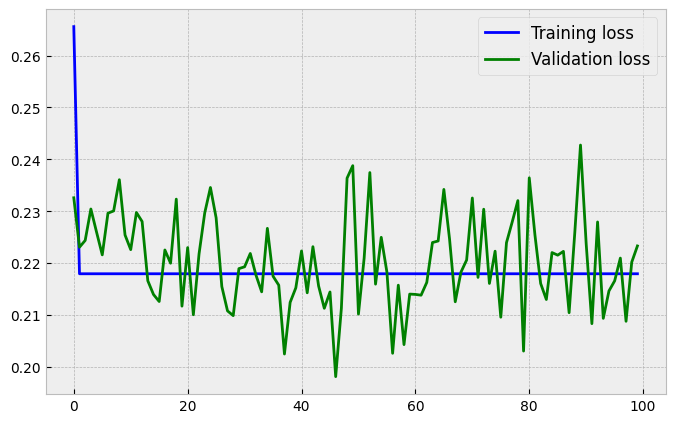

In [14]:
from utility_functions import *

ax = plot(history_l1,'b',label='Training loss')
ax = plot(history_l1val,'g',label='Validation loss', ax=ax)